# Assignment 4: Feature points, matching, homography


## Exercise 1: Feature points detectors
In this exercise you will implement two frequently used feature point detectors: the Hessian
algorithm and the Harris algorithm.

In [16]:
#imports
import numpy as np
from matplotlib import pyplot as plt
from a4_utils import *
import cv2 as cv2
from UZ_utils import *
import math
import os

### A)
Implement a function hessian_points, that computes a Hessian determinant using
the equation for each pixel of the input image. As this computation can be
very slow if done pixel by pixel, you have to implement it using vector operations
(without explicit for loops). Test the function using image from test_points.jpg
as your input (do not forget to convert it to grayscale) and visualize the result.


In [19]:
def get_image_derivetive(image, sigma):
    gaus = np.array(gauss(sigma))

    gaus_dx = np.array(gaussdx(sigma))
    gaus_dx = np.flip(gaus_dx)

    I_x = cv2.filter2D(image, -1, gaus.T)
    I_x = cv2.filter2D(I_x, -1, gaus_dx)

    I_y = cv2.filter2D(image, -1, gaus)
    I_y = cv2.filter2D(I_y, -1, gaus_dx.T)

    return I_x, I_y


def get_second_image_derivative(image, sigma):
    gaus = np.array(gauss(sigma))
    gaus_dx = np.array(gaussdx(sigma))
    gaus_dx = np.flip(gaus_dx)

    I_x, I_y = get_image_derivetive(image, sigma)

    I_xx = cv2.filter2D(I_x, -1, gaus.T)
    I_xx = cv2.filter2D(I_xx, -1, gaus_dx)

    I_yy = cv2.filter2D(I_y, -1, gaus)
    I_yy = cv2.filter2D(I_yy, -1, gaus_dx.T)

    I_xy = cv2.filter2D(I_x, -1, gaus)
    I_xy = cv2.filter2D(I_xy, -1, gaus_dx.T)

    return I_xx, I_yy, I_xy

1
2
3


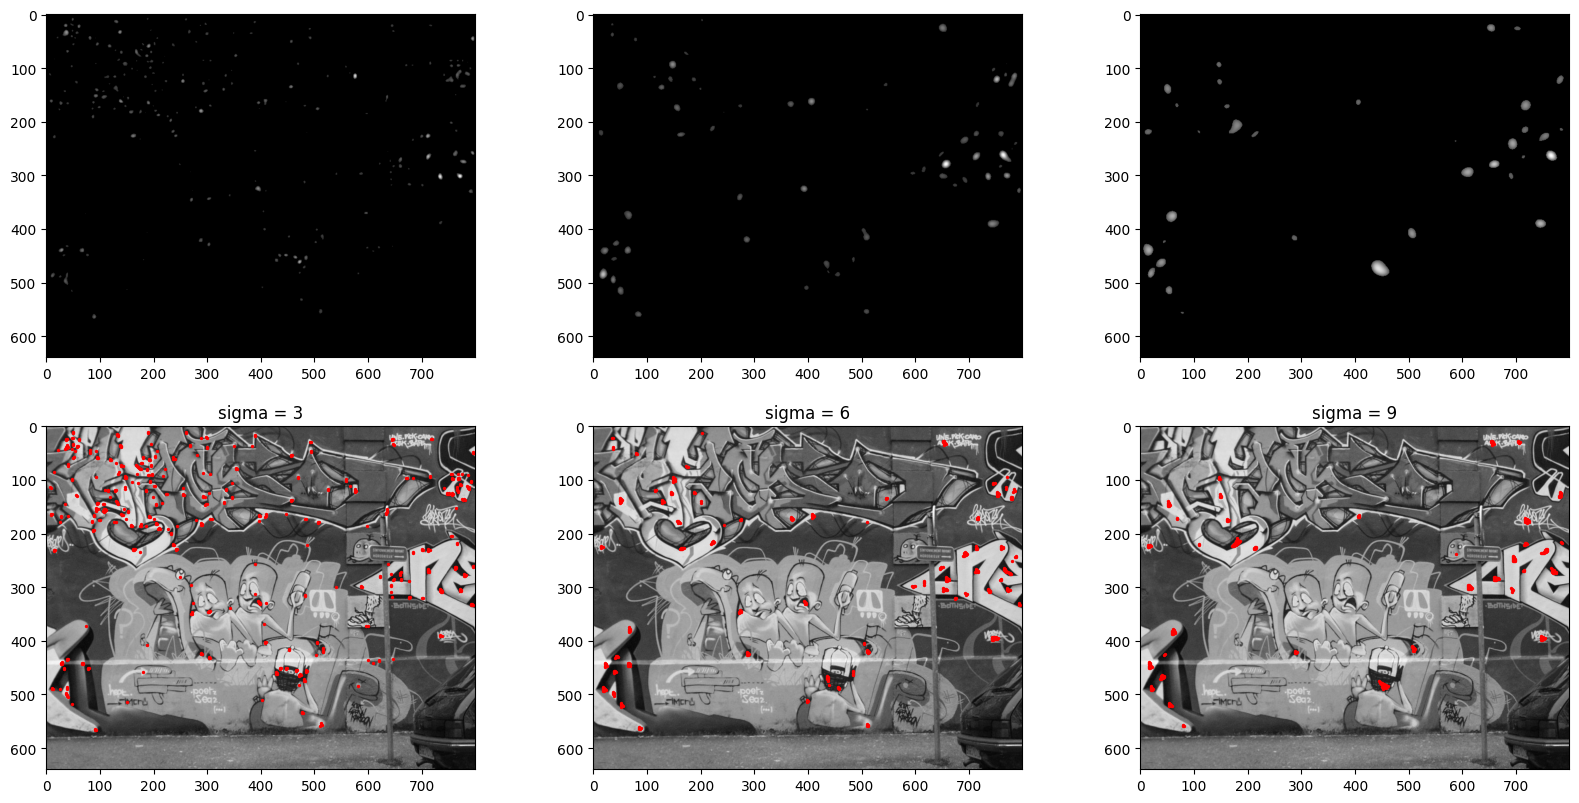

In [99]:
def non_maxima_box(image):
  for i in range(1, len(image)-1):
      for j in range(1, len(image[0])-1):
          neigbours = image[-1+i:i+2, j-1:j+2]
          if image[i, j] < np.max(neigbours):
              image[i, j] = 0
  return image

def non_maxima_box_n(image,n):
  for i in range(n, len(image)-n):
      for j in range(n, len(image[0])-n):
          neigbours = image[-n+i:i+n+1, j-n:j+n+1]
          if image[i, j] < np.max(neigbours):
              image[i, j] = 0
  return image

def hessian_points(image, sigma, treshold):
  I_xx, I_yy, I_xy = get_second_image_derivative(image, sigma)
  det = np.multiply(I_xx, I_yy) - np.square(I_xy)
  det[det<treshold] = 0
  return det

  
plt.rcParams['figure.figsize'] = [20, 10]
plt.rcParams['figure.dpi'] = 100 # 200 e.g. is really fine, but slower

fig, ax = plt.subplots(2, 3)

for i in range(1,4):
  print(i)
  image = imread_gray("./data/graf/graf_a.jpg")
  test = hessian_points(image, i*3, 0.004)
  ax[0,i-1].imshow(test)
  testa = test.copy()
  det = non_maxima_box(test)
  det[det>0] = 1
  ax[1, i-1].imshow(image, cmap="gray")
  ax[1, i-1].scatter(np.where(det != 0)[1], np.where(det != 0)[0],marker = "o", c="red", s=2)
  ax[1, i-1].set_title("sigma = " + str(i  * 3))



#### Question: What kind of structures in the image are detected by the algorithm? How does the parameter sigma affect the result?
#### Answer: It detects blobs


### B)
Implement the Harris feature point detector. This detector is based on the autocorrelation
matrix C that measures the level of self-similarity for a pixel neighborhood
for small deformations. At the lectures, you have been told that the Harris
detector chooses a point (x; y) for a feature point if both eigenvalues of the
auto-correlation matrix for that point are large. This means that the neighborhood
of (x; y) contains two well-defined rectangular structures – i.e. a corner. Autocorrelation
matrix can be computed using the first partial derivatives at (x; y) that
2
are subsequently smoothed using a Gaussian filter

1
2
3


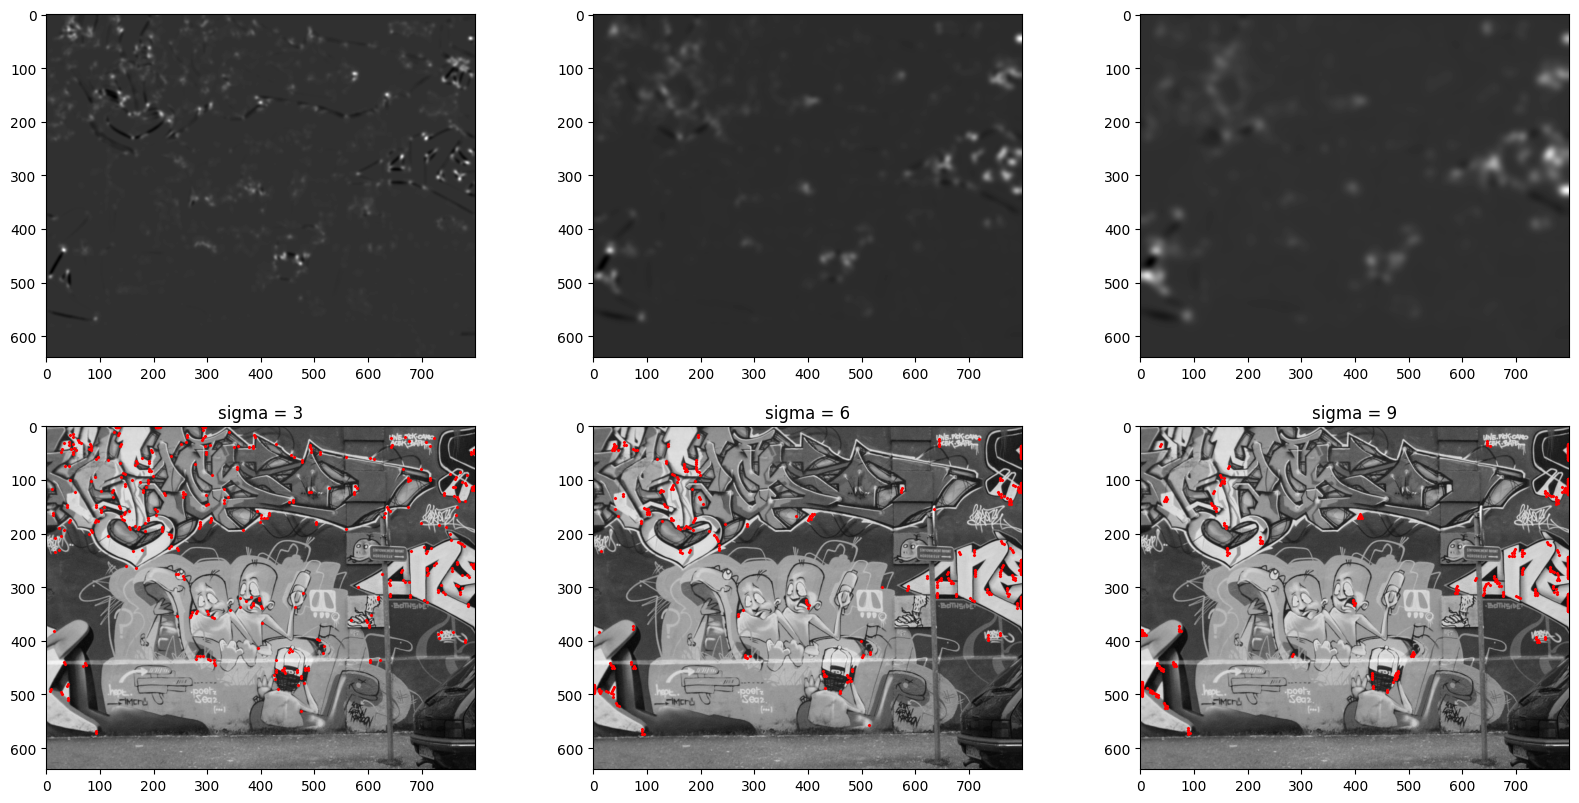

In [114]:
def auto_corelation(image,sigma_picture,sigma_derivetive):
  image = image.copy()
  I_x, I_y = get_image_derivetive(image, sigma_derivetive)
  gaus_kernel = np.array(gauss(sigma_picture))
  i_xx = I_x**2
  i_yy = I_y**2
  i_xy = I_x*I_y
  # det of C
  one = cv2.filter2D(i_xx, -1, gaus_kernel)
  one = cv2.filter2D(one, -1, gaus_kernel.T)
  two = cv2.filter2D(i_xy, -1, gaus_kernel)
  two = cv2.filter2D(two, -1, gaus_kernel.T)
  three = cv2.filter2D(i_xy, -1, gaus_kernel)
  three = cv2.filter2D(three, -1, gaus_kernel.T)
  four = cv2.filter2D(i_yy, -1, gaus_kernel)
  four = cv2.filter2D(four, -1, gaus_kernel.T)
  det = np.multiply(one, four) - np.multiply(two, three)
  trace = one + four
  return det - 0.04 * np.square(trace)
  

fig, ax = plt.subplots(2, 3)
for i in range(1,4):
  print(i)
  image = imread_gray("./data/graf/graf_a.jpg")
  test = auto_corelation(image, sigma_picture=3*i, sigma_derivetive=(3*i)/1.6)
  test_cpy = test.copy()
  test_cpy[test_cpy<0.00004] = 0
  test_cpy = non_maxima_box_n(test_cpy, 3)
  ax[0,i-1].imshow(test)
  ax[1, i-1].imshow(image, cmap="gray")
  ax[1, i-1].scatter(np.where(test_cpy != 0)[1], np.where(test_cpy != 0)[0], c="red", s=2, marker="x")
  ax[1, i-1].set_title("sigma = " + str(i  * 3))


#### Question : Do the feature points of both detectors appear on the same structures in the image?

#### Answer: yes in most cases they do. We are looking for corners blobs,....

## Exercise 2: Matching local regions
One of the uses of feature points is searching for similar structures in different images.
To do this, we will need descriptors of the regions around these points. In this
assignment you will implement some simple descriptors as well as their matching.

### A)
Use the function simple_descriptors from a4_utils.py to calculate descriptors
for a list of feature points. Then, write a function find_correspondences which
calculates similarities between all descriptors in two given lists. Use Hellinger
distance (see Assignment 2). Finally, for each descriptor from the first list, find
the most similar descriptor from the second list. Return a list of [a; b] pairs, where
a is the index from the first list, and b is the index from the second list.
Write a script that loads images graf/graf_a_small.jpg and graf/graf_b_small.jpg,
runs the function find_correspondences and visualizes the result. Use the function
display_matches from the supplementary material for visualization. Experiment
with different parameters for descriptor calculation and report on the
changes that occur.

In [115]:
def helliger(x, y):
    return np.sqrt(0.5 * np.sum(np.square(np.sqrt(x) - np.sqrt(y))))

In [118]:
def find_correspondences(desc1, desc2):
  print("find correspondences")
  # calculates similarities between all descriptors in two given lists. Use Hellinger
# distance (see Assignment 2). Finally, for each descriptor from the first list, find
# the most similar descriptor from the second list. Return a list of [a; b] pairs, where
# a is the index from the first list, and b is the index from the second list.
  correspondences = []
  for i in range(len(desc1)):
    distances = []
    for j in range(len(desc2)):
      distances.append(helliger(desc1[i], desc2[j]))
    correspondences.append([i, np.argmin(distances)])
  return correspondences


image1 = imread_gray("./data/graf/graf_a_small.jpg")
image2 = imread_gray("./data/graf/graf_b_small.jpg")
print("here")
sigma = 3
feature1 = auto_corelation(image1, sigma, sigma/1.6)
feature2 = auto_corelation(image2, sigma, sigma/1.6)
print("dva")
f1_x, f1_y = np.where(feature1 > 0.00004)
f2_x, f2_y = np.where(feature2 > 0.00004)
print("tri")
descriptors_1 = simple_descriptors(image1, f1_x, f1_y)
descriptors_2 = simple_descriptors(image2, f2_x, f2_y)
print("stiri")


here
dva
tri
stiri


In [119]:
find_correspondences(descriptors_1, descriptors_2)

find correspondences
